In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, mean_squared_error

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    x_train_idx = np.arange(len(x_train))  # create a list of index
    np.random.shuffle(x_train_idx)
    num_elements = int(len(x_train) / k)
    kfold_data = []
    for i in range(k):  # iterate over k to get k-fold index
        tmp_train = []
        tmp_val = np.sort(x_train_idx[i:num_elements*k:k]) # get valid data
        # put others to training data
        for j in range(len(x_train)):
            if j not in tmp_val:
                tmp_train.append(j)
        tmp_train = np.array(tmp_train)
        kfold_data.append([tmp_train, tmp_val])
    return kfold_data

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)

In [7]:
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

## Example

In [8]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  4  5  7  9 10 11 12 13 15 16 17 18 19], Validation index: [ 3  6  8 14]
Split: 2, Training index: [ 2  3  4  6  7  8  9 11 12 13 14 15 16 17 18 19], Validation index: [ 0  1  5 10]
Split: 3, Training index: [ 0  1  2  3  5  6  7  8 10 11 12 14 15 16 18 19], Validation index: [ 4  9 13 17]
Split: 4, Training index: [ 0  1  3  4  5  6  8  9 10 11 13 14 15 16 17 18], Validation index: [ 2  7 12 19]
Split: 5, Training index: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 17 19], Validation index: [11 15 16 18]


In [9]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [10]:
c_list = [0.1, 1, 10, 100, 1000, 1e4, 1e5]
gamma_list = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10]

The gridsearch function below is for SVM classification and regression.

You can pass in the list of 'C' and 'gamma', which are important hyperparameters in SVM.

It is going to find two hyperparameter one is 'C' and the other is 'gamma' for you.

Specify the task you to do using 'mode' parameter.

In [11]:
def gridsearch(x, y, c_list, gamma_list, mode='clf', k=5):
    scores = []
    for c in c_list:
        tmp_scores = []  # record the column of scores
        for gamma in gamma_list:
            kfold_idx = cross_validation(x, y, k=k)
            avg_score = 0  # accumulate the accuracy in each fold
            for fold_idx in kfold_idx:
                if mode == 'clf':
                    model = SVC(C=c, kernel='rbf', gamma=gamma)
                else:
                    model = SVR(C=c, kernel='rbf', gamma=gamma)
                model.fit(x[fold_idx[0]], y[fold_idx[0]])
                avg_score += model.score(x[fold_idx[1]], y[fold_idx[1]]) / k
            tmp_scores.append(avg_score)
        scores.append(tmp_scores)
    scores = np.array(scores)
    return scores, np.unravel_index(np.argmax(scores, axis=None), scores.shape)

In [12]:
acc_array, idx = gridsearch(x_train, y_train, c_list, gamma_list, mode='clf')

In [13]:
best_parameters = {'C': c_list[idx[0]], 'Gamma': gamma_list[idx[1]]}
print(f'Best parameters: {best_parameters}')
print(f'Best acc: {acc_array[idx]}')

Best parameters: {'C': 10000.0, 'Gamma': 0.001}
Best acc: 0.8909090909090909


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

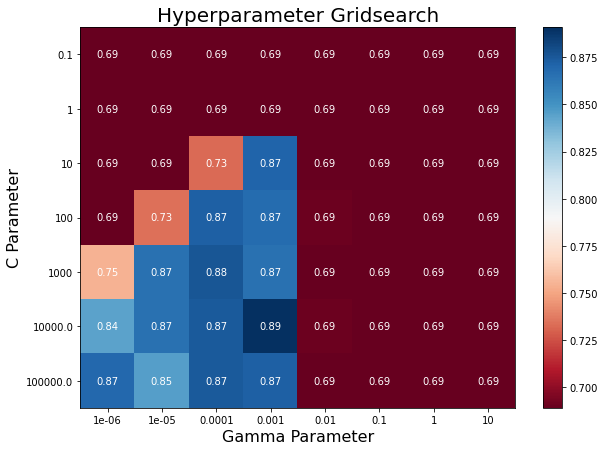

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 7))
c = plt.imshow(acc_array, cmap=plt.get_cmap('RdBu'))

# draw x and y value
plt.xticks(np.arange(len(gamma_list)), gamma_list)
plt.yticks(np.arange(len(c_list)), c_list)

# put the acc on the blocks
for i in range(len(c_list)):
    for j in range(len(gamma_list)):
        text = plt.text(j, i, np.around(acc_array[i, j], 2),
                        ha="center", va="center", color="w")

plt.xlabel('Gamma Parameter', fontsize=16)
plt.ylabel('C Parameter', fontsize=16)
plt.title('Hyperparameter Gridsearch', fontsize=20)
plt.colorbar(c)
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [15]:
best_model = SVC(C=best_parameters['C'], kernel='rbf', gamma=best_parameters['Gamma'])
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.8958333333333334


## Question 5
Compare the performance of the model you have implemented in HW1 with the SVM

In [16]:
train_df = pd.read_csv("../HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1,1)
y_train = train_df['y_train'].to_numpy().reshape(-1,1)

test_df = pd.read_csv("../HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1,1)
y_test = test_df['y_test'].to_numpy().reshape(-1,1)

### Linear Regression

In [17]:
class LinearRegression:
    def __init__(self, it=100, lr=1e-4):
        self.w = np.random.rand(2)
        self.it = 100
        self.lr = lr
        return
    
    def fit(self, x, y):
        for i in range(self.it):
            bias_x = np.insert(x, 0, 1, axis=1)
            pred = np.dot(bias_x, self.w)
            grad = np.dot(np.transpose(bias_x), np.subtract(pred, y))
            self.w = self.w - self.lr * grad
        return
    
    def pred(self, x):
        bias_x = np.insert(x, 0, 1, axis=1)
        pred = np.dot(bias_x, self.w)
        return pred

In [18]:
linear_regr = LinearRegression()
linear_regr.fit(x_train, y_train.ravel())

In [19]:
pred_linear = linear_regr.pred(x_test)

### SVR

In [20]:
c_list = [0.1, 1, 10, 100, 1000, 1e4, 1e5, 1e6]
gamma_list = [1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10]

In [21]:
scores, idx = gridsearch(x_train, y_train.ravel(), c_list, gamma_list, mode='regr')

best_parameters = {'C': c_list[idx[0]], 'Gamma': gamma_list[idx[1]]}

In [22]:
best_model = SVR(C=best_parameters['C'], kernel='rbf', gamma=best_parameters['Gamma'])
best_model.fit(x_train, y_train.ravel())

pred_svr = best_model.predict(x_test)

In [23]:
print(f"Square error of Linear regression: {mean_squared_error(pred_linear, y_test.ravel())}")
print(f"Square error of SVM regression model: {mean_squared_error(pred_svr, y_test.ravel())}")

Square error of Linear regression: 0.4909021821186157
Square error of SVM regresssion model: 0.49449139266015857
